<a href="https://colab.research.google.com/github/RohithKuditipudi/blackbox-model-tracing/blob/main/scripts/pile_sequence_pplx_plots.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Setup

In [ ]:
DATA_DIR = '/nlp/scr/rohithk/data'
MODEL_DIR = '/nlp/scr/rohithk/models'
SCR_MODEL_DIR = '/nlp/scr/hij/memorization/models'

# Plots

In [ ]:
import json
import numpy as np
import os
import random

import torch

seq_to_source = {}

for step in [5, 25, 50, 75, 100]:
  data = json.load(open(os.path.join(SCR_MODEL_DIR, f'pythia-6.9b-deduped_pile_step{step}k_{step+1}k_sampled_200k_prefix_len32_to_outputs_len32.json')))
  full_seqs = set([k + v['label'] for k, v in data.items()])
  for s in full_seqs:
    seq_to_source[s] = step # what if same sequence appears in multiple steps?

## PPLX vs. sampled step

Text(0.5, 0, 'Checkpoint at Step (K)')

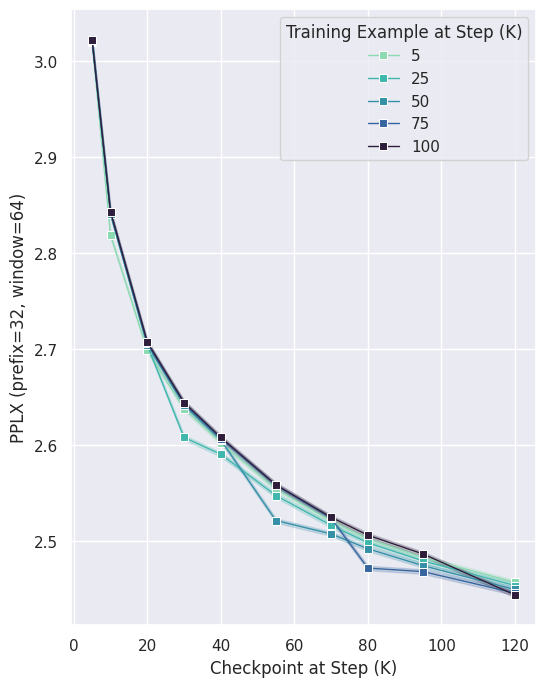

In [ ]:
# pythia-6.9b-deduped
# Sequences from the same training step at 5K, 25K, 50K, 75K, and 100K (which is the second pass of the data).

import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
sns.set_theme()

import collections


revisions = [
    'step5000',
    'step10000',
    'step20000',
    'step30000',
    'step40000',
    'step55000',
    'step70000',
    'step80000',
    'step95000',
    'step120000',
]

prefix_len = 32
data = []
seq_to_pplx_all = collections.defaultdict(list)
for revision in revisions:
  seq_to_pplx = torch.load(os.path.join(MODEL_DIR, f'seq_to_pplx_1m_p32_w64_pythia-6.9b-deduped_{revision}.pt'))
  for i, (seq, pplx) in enumerate(seq_to_pplx.items()):
    pplx = pplx[prefix_len:].mean().tolist()
    if np.isnan(pplx):
      continue
    seq_to_pplx_all[seq].append(pplx)
    data.append({'pplx': pplx, 'Training Example at Step (K)': seq_to_source[seq], 'ckpt': int(revision.split('step')[1]) // 1000, 'seq': repr(seq[:16])})

filtered_seq = set([repr(s[:16]) for s in seq_to_pplx_all
                    # Filter out sequences that likely occurs multiple times in training, i.e., pplx > mean-std pplx at checkpoint 120K.
                    if min(seq_to_pplx_all[s]) > 1.8 and # why is this necessary?
                    # Filter out outlier sequences, i.e., pplx outside one std at checkpoint 5K.
                    seq_to_pplx_all[s][0] > 2.0 and seq_to_pplx_all[s][0] < 3.7])


plt.figure(figsize=(6, 8))
plt.rcParams['figure.dpi'] = 300
plt.rcParams['savefig.dpi'] = 300


colors = sns.color_palette("mako")
data = pd.DataFrame([x for x in data if x['seq'] in filtered_seq])
ax = sns.lineplot(data, x='ckpt', y='pplx', hue='Training Example at Step (K)', marker='s', linewidth=1,
                  palette=[colors[5], colors[4], colors[3], colors[2], colors[0]])
ax.set_ylabel(f'PPLX (prefix={prefix_len}, window={96-prefix_len})')
ax.set_xlabel(f'Checkpoint at Step (K)')

Text(0.5, 0, 'Checkpoint at Step (K)')

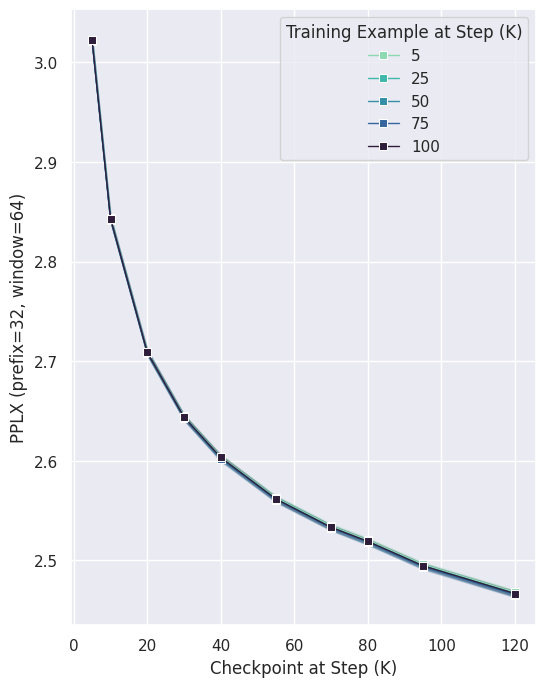

In [ ]:
# Same 1M sequences, scored with pythia-6.9b, which uses a different training order.
# Sequences from the same training step at 5K, 25K, 50K, 75K, and 100K (which is the second pass of the data).

import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
sns.set_theme()

import collections


revisions = [
    'step5000',
    'step10000',
    'step20000',
    'step30000',
    'step40000',
    'step55000',
    'step70000',
    'step80000',
    'step95000',
    'step120000',
]

prefix_len = 32
data = []
seq_to_pplx_all = collections.defaultdict(list)
for revision in revisions:
  seq_to_pplx = torch.load(os.path.join(MODEL_DIR, f'seq_to_pplx_1m_p32_w64_pythia-6.9b_{revision}.pt'))
  for i, (seq, pplx) in enumerate(seq_to_pplx.items()):
    pplx = pplx[prefix_len:].mean().tolist()
    if np.isnan(pplx):
      continue
    seq_to_pplx_all[seq].append(pplx)
    data.append({'pplx': pplx, 'Training Example at Step (K)': seq_to_source[seq], 'ckpt': int(revision.split('step')[1]) // 1000, 'seq': repr(seq[:16])})

filtered_seq = set([repr(s[:16]) for s in seq_to_pplx_all
                    # Filter out sequences that likely occurs multiple times in training, i.e., pplx > mean-std pplx at checkpoint 120K.
                    if min(seq_to_pplx_all[s]) > 1.8 and
                    # Filter out outlier sequences, i.e., pplx outside one std at checkpoint 5K.
                    seq_to_pplx_all[s][0] > 2.0 and seq_to_pplx_all[s][0] < 3.7])


plt.figure(figsize=(6, 8))
plt.rcParams['figure.dpi'] = 300
plt.rcParams['savefig.dpi'] = 300


colors = sns.color_palette("mako")
data = pd.DataFrame([x for x in data if x['seq'] in filtered_seq])
ax = sns.lineplot(data, x='ckpt', y='pplx', hue='Training Example at Step (K)', marker='s', linewidth=1,
                  palette=[colors[5], colors[4], colors[3], colors[2], colors[0]])
ax.set_ylabel(f'PPLX (prefix={prefix_len}, window={96-prefix_len})')
ax.set_xlabel(f'Checkpoint at Step (K)')

## PPLX difference vs. sampled step

In [ ]:
seq_to_pplx = torch.load(os.path.join(MODEL_DIR, f'seq_to_pplx_63k_p32_w64_pythia-6.9b-deduped_step5000.pt'))
sampled = []
for step in [5, 25, 50, 75, 100]:
 sampled.extend(random.sample(list([s for s in seq_to_pplx if seq_to_source[s] == step #and s in select_seq
                                    ]), k=5000))
sampled = set(sampled)
len(sampled)

Text(0.5, 0, 'Checkpoint at Step (K)')

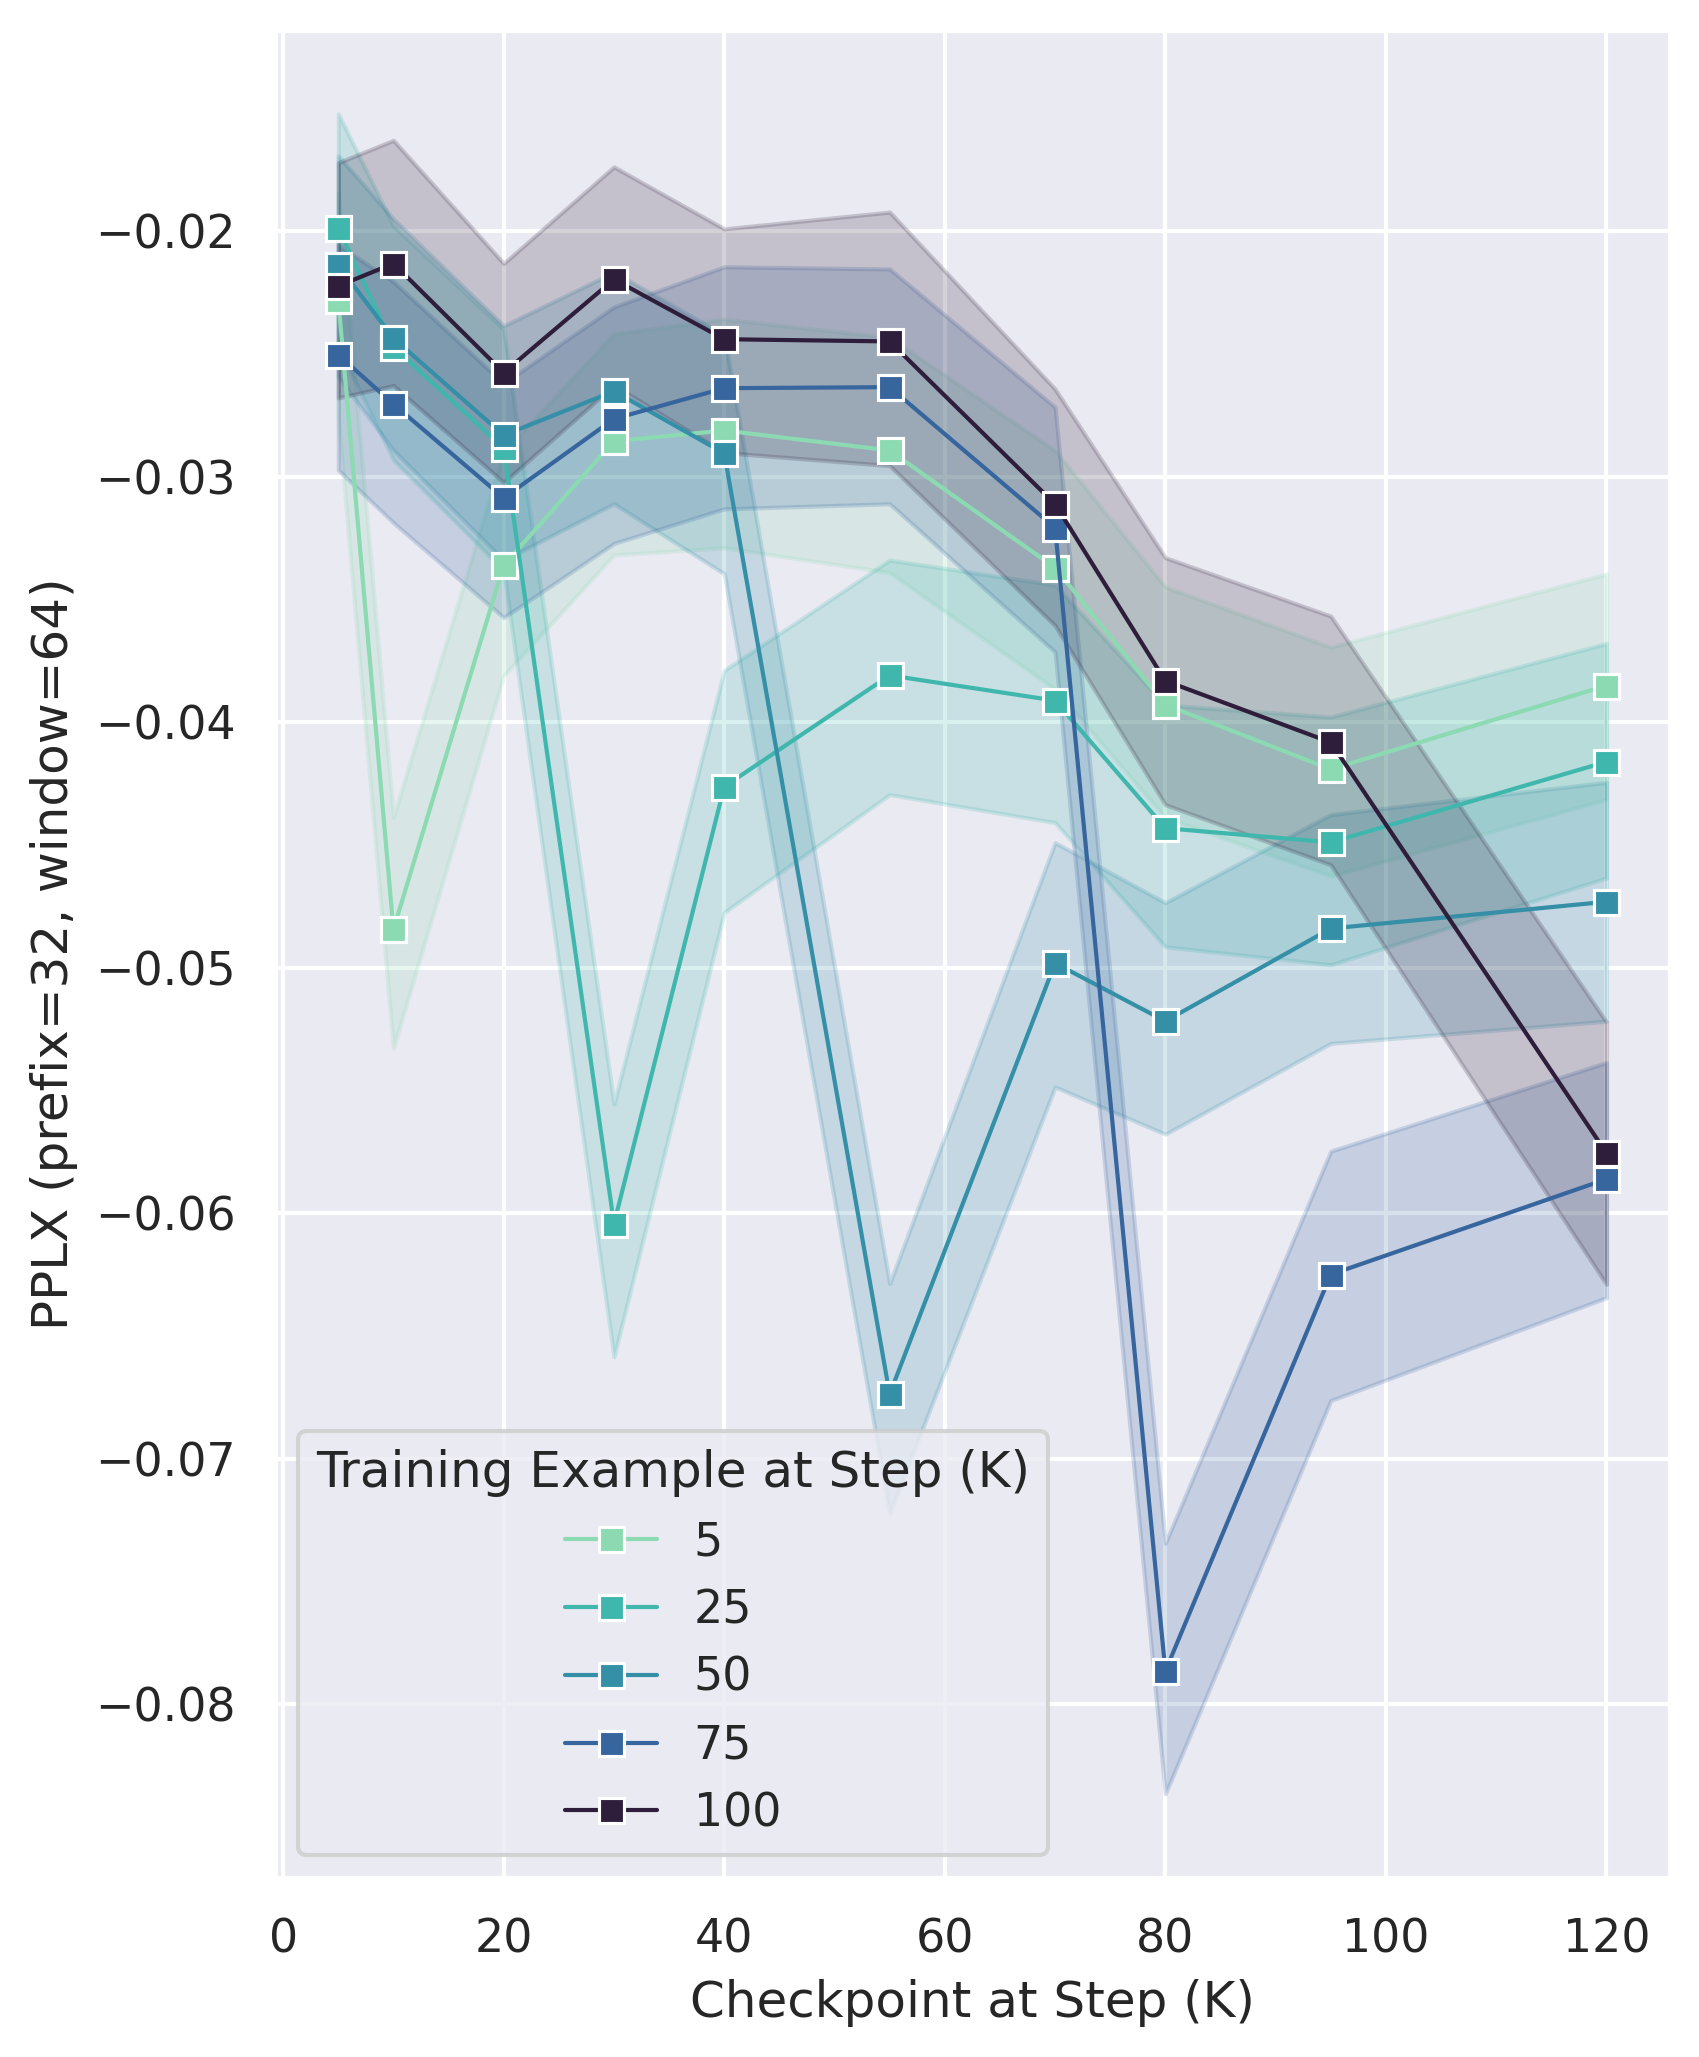

In [ ]:
# Diff with a baseline
# Sequences from the same training step at 5K, 25K, 50K, 75K, and 100K (which is the second pass of the data).

import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
sns.set_theme()

import collections


revisions = [
    'step5000',
    'step10000',
    'step20000',
    'step30000',
    'step40000',
    'step55000',
    'step70000',
    'step80000',
    'step95000',
    'step120000',
]

prefix_len = 32
data = []
seq_to_pplx_all = collections.defaultdict(list)

for revision in revisions:
  # We only need ~50K data here to distinguish the training example order.
  seq_to_pplx = torch.load(os.path.join(MODEL_DIR, f'seq_to_pplx_63k_p32_w64_pythia-6.9b-deduped_{revision}.pt'))
  seq_to_pplx_unordered = torch.load(os.path.join(MODEL_DIR, f'seq_to_pplx_1m_p32_w64_pythia-6.9b_{revision}.pt'))
  for i, (seq, pplx) in enumerate(seq_to_pplx.items()):
    if seq not in sampled:
      continue
    pplx = pplx[prefix_len:].mean().tolist()
    pplx_unordered = seq_to_pplx_unordered[seq][prefix_len:].mean().tolist()
    if np.isnan(pplx):
      continue
    seq_to_pplx_all[seq].append(pplx)
    data.append({'pplx': pplx - pplx_unordered, 'Training Example at Step (K)': seq_to_source[seq], 'ckpt': int(revision.split('step')[1]) // 1000, 'seq': repr(seq[:16])})

filtered_seq = set([repr(s[:16]) for s in seq_to_pplx_all
                    # Filter out sequences that likely occurs multiple times in training, i.e., pplx > mean-std pplx at checkpoint 120K.
                    if min(seq_to_pplx_all[s]) > 1.8
                    ])


plt.figure(figsize=(6, 8))
plt.rcParams['figure.dpi'] = 300
plt.rcParams['savefig.dpi'] = 300


colors = sns.color_palette("mako")
data = pd.DataFrame([x for x in data if x['seq'] in filtered_seq])
ax = sns.lineplot(data, x='ckpt', y='pplx', hue='Training Example at Step (K)', marker='s', linewidth=1,
                  palette=[colors[5], colors[4], colors[3], colors[2], colors[0]])
ax.set_ylabel(f'PPLX (prefix={prefix_len}, window={96-prefix_len})')
ax.set_xlabel(f'Checkpoint at Step (K)')

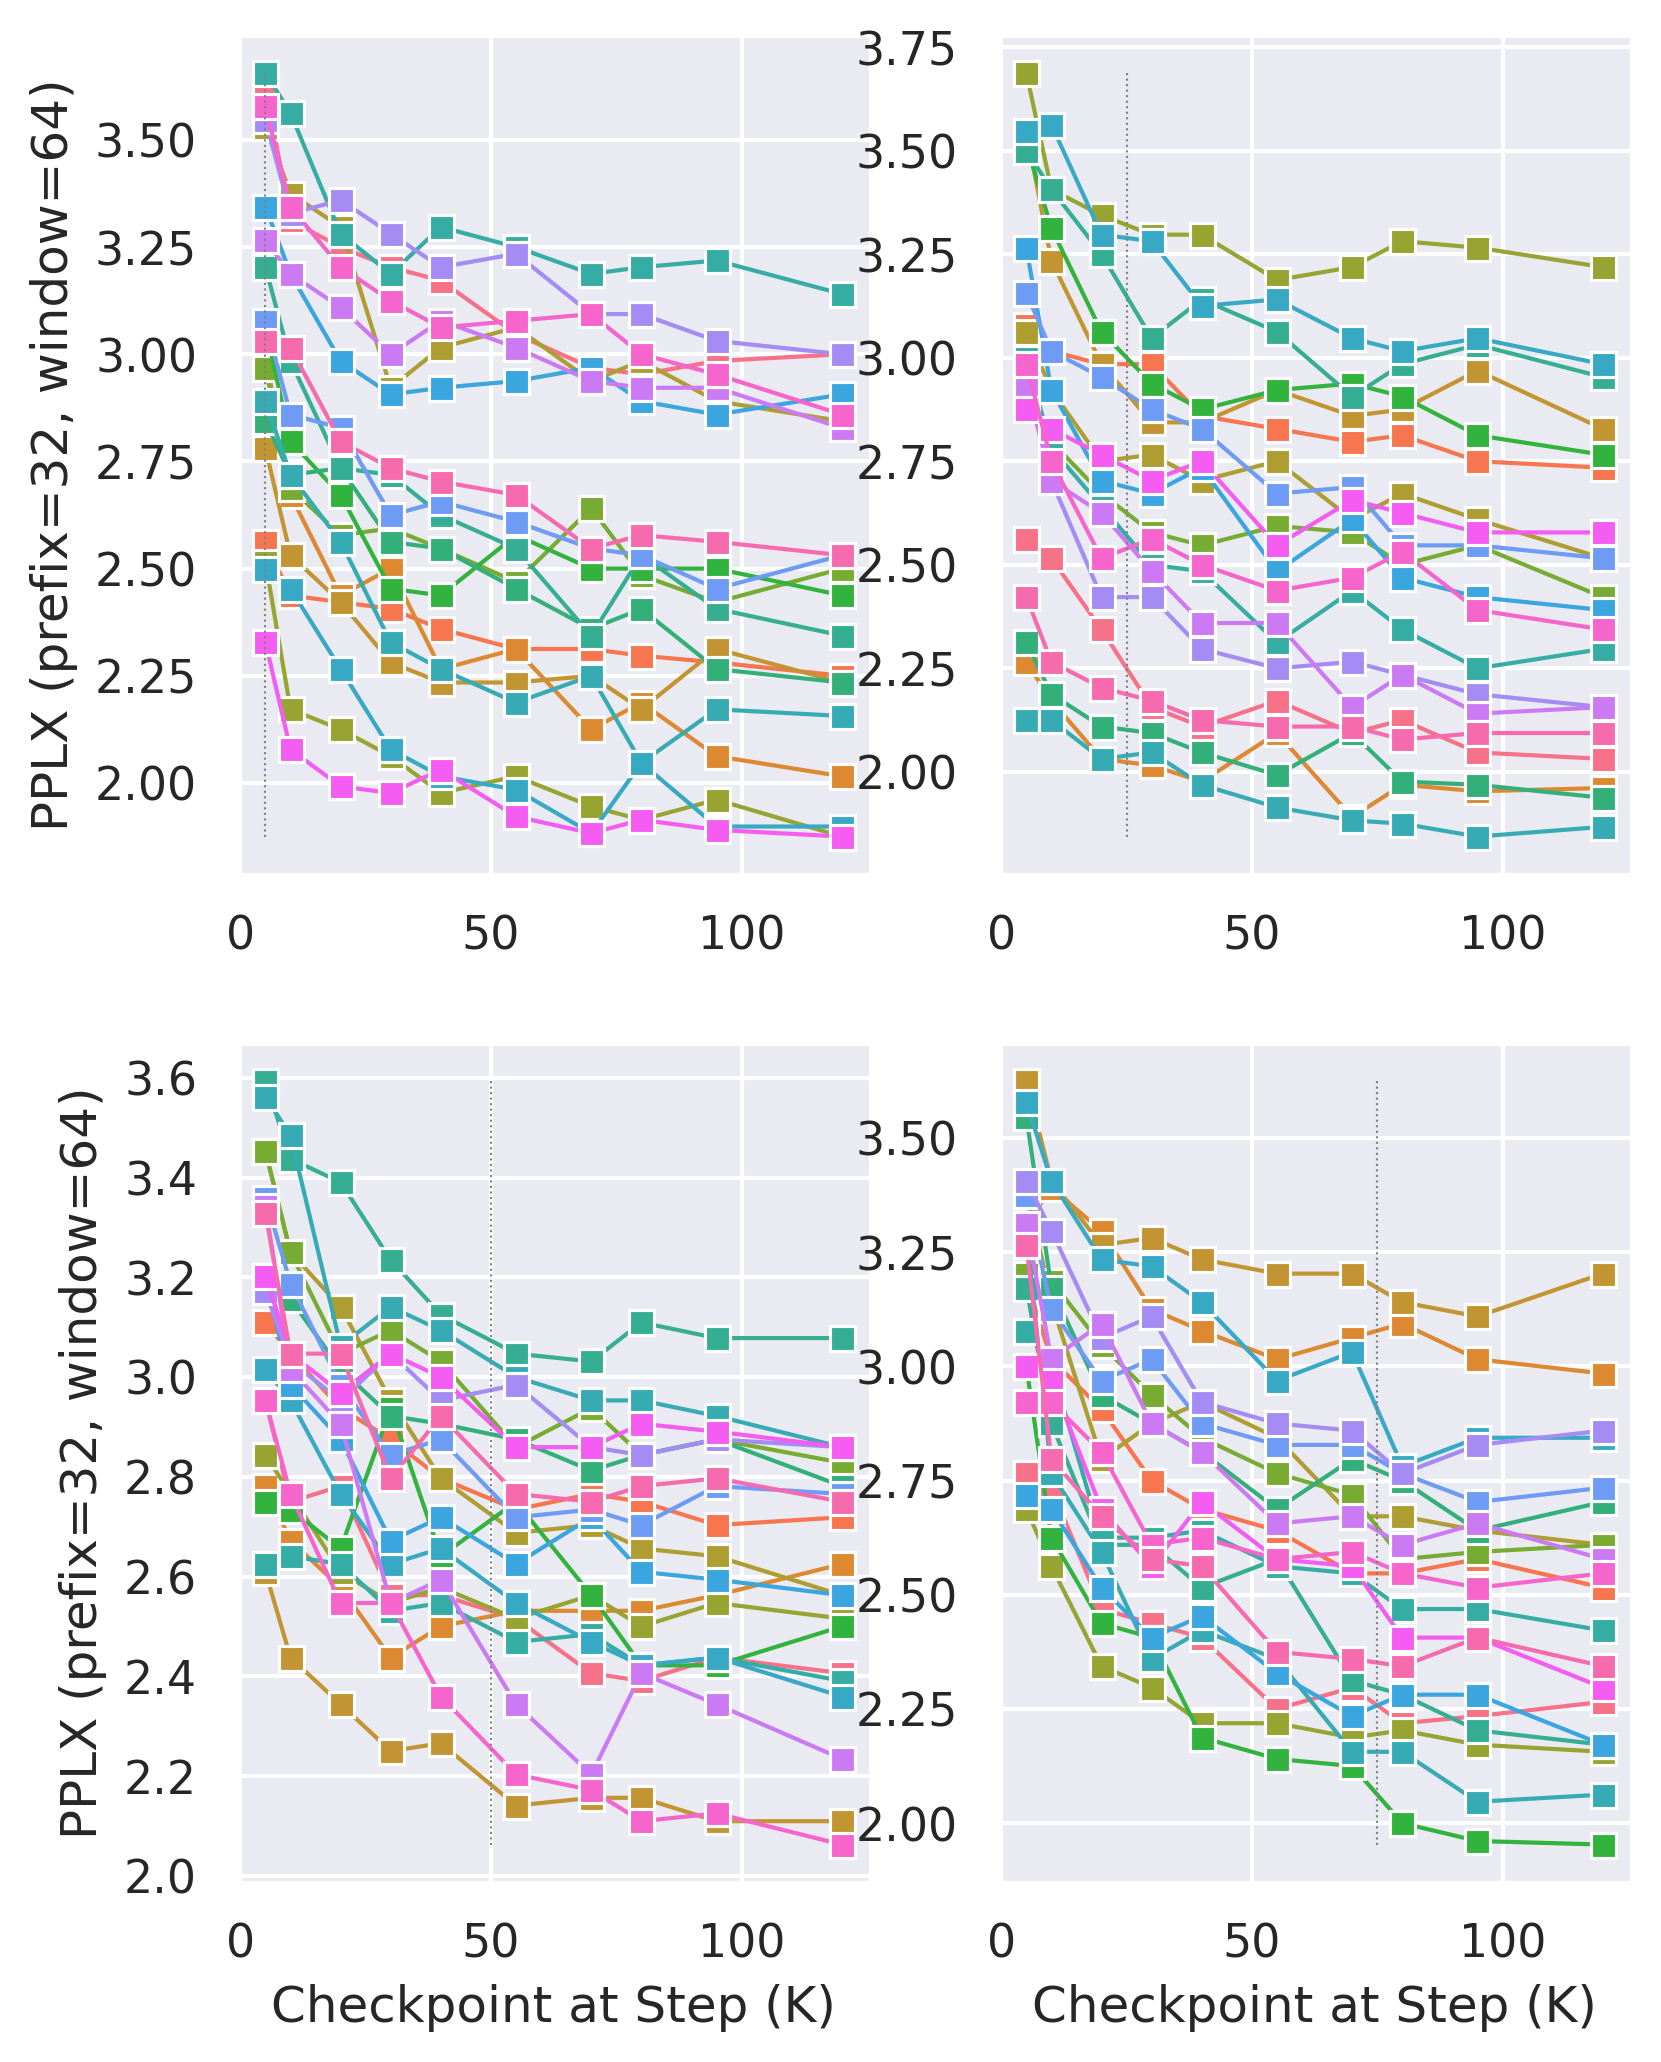

In [ ]:
# Randomly sampled individual sequences.

import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
sns.set_theme()

import collections


revisions = [
    'step5000',
    'step10000',
    'step20000',
    'step30000',
    'step40000',
    'step55000',
    'step70000',
    'step80000',
    'step95000',
    'step120000',
]

data = []
seq_to_pplx_all = collections.defaultdict(list)
for revision in revisions:
  seq_to_pplx = torch.load(os.path.join(MODEL_DIR, f'seq_to_pplx_63k_p32_w64_pythia-6.9b-deduped_{revision}.pt'))
  for i, (seq, pplx) in enumerate(seq_to_pplx.items()):
    pplx = pplx[prefix_len:].mean().tolist()
    if np.isnan(pplx):
      continue
    seq_to_pplx_all[seq].append(pplx)
    data.append({'pplx': pplx, 'Training Example at Step (K)': seq_to_source[seq], 'ckpt': int(revision.split('step')[1]) // 1000, 'seq': seq})

filtered_seq = set([s for s in seq_to_pplx_all
                    # Filter out sequences that likely occurs multiple times in training, i.e., pplx > mean-std pplx at checkpoint 120K.
                    if min(seq_to_pplx_all[s]) > 1.8 and
                    # Filter out outlier sequences, i.e., pplx outside one std at checkpoint 5K.
                    seq_to_pplx_all[s][0] > 2.0 and seq_to_pplx_all[s][0] < 3.7
                    ])

fig, axes = plt.subplots(2, 2, figsize=(6, 8))
plt.rcParams['figure.dpi'] = 300
plt.rcParams['savefig.dpi'] = 300


for i, c in enumerate([5, 25, 50, 75]):
  sub_filtered_seq = set(random.sample([s for s in filtered_seq if seq_to_source[s] == c], k=20))
  sub_data = pd.DataFrame([x for x in data if x['seq'] in sub_filtered_seq])
  ax = sns.lineplot(sub_data, x='ckpt', y='pplx', hue='seq', marker='s', linewidth=1, ax=axes[i // 2, i % 2])
  ax.set_ylabel(f'PPLX (prefix={prefix_len}, window={96-prefix_len})' if i % 2 == 0 else '')
  ax.set_xlabel(f'Checkpoint at Step (K)' if i // 2 == 1 else '')
  ax.vlines(c, np.min(sub_data['pplx']), np.max(sub_data['pplx']), linestyles='dotted', linewidth=0.5, colors='gray')
  ax.legend().set_visible(False)